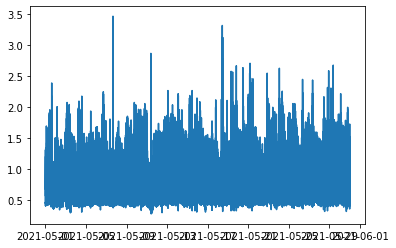

In [2]:
import sqlite3 as db
import pandas as pd
import statsmodels.api as sm
from datetime import datetime
import sqlite3 as db
import pandas as pd
import statsmodels.api as sm
from datetime import datetime
import matplotlib.pyplot as plt
database = "/home/sachin/Downloads/RWO_0004_Ventilatoren_00.sqlite"

con = db.connect(database)
df = pd.read_sql_query(f"SELECT time, value FROM Value WHERE sensor_id=2 AND "
                       f"time >= '{1619820000000}' AND time < '{1622411999000}'",
                       con)
df["time"] = df["time"].apply(lambda utc: datetime.fromtimestamp(int(utc / 1000)))
df.drop_duplicates(subset="time", keep="first", inplace=True)
df.index = df['time']
df = df.reindex(pd.date_range(min(df.index),
                              max(df.index),
                              freq='S'))
df.drop('time', axis=1, inplace=True)
df = df.interpolate().fillna(method='bfill')
con.close()
plt.plot(df)
plt.show()

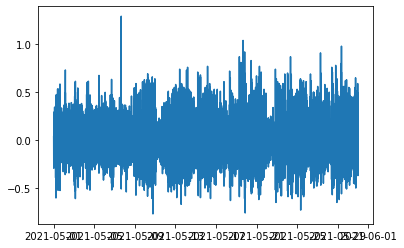

In [10]:
walk_diff = df["value"].diff()
walk_diff = walk_diff.dropna()

plt.plot(walk_diff);

In [11]:
print(df)
print(df['value'].mean())

                        value
2021-05-01 00:00:00  0.568429
2021-05-01 00:00:01  0.604371
2021-05-01 00:00:02  0.603123
2021-05-01 00:00:03  0.707030
2021-05-01 00:00:04  0.771171
...                       ...
2021-05-30 23:59:54  0.550000
2021-05-30 23:59:55  0.560000
2021-05-30 23:59:56  0.540000
2021-05-30 23:59:57  0.560000
2021-05-30 23:59:58  0.580000

[2591999 rows x 1 columns]
0.6908472650080114


In [ ]:
from statsmodels.graphics.tsaplots import plot_acf
fig = plot_acf(df)
plt.show();

In [12]:
import matplotlib.pyplot as plt
new = df.resample('T').mean()
# new = df

# new = new.diff().dropna()
result = sm.tsa.stattools.adfuller(new["value"])
print(f'ADF Statistic: {result[0]}')
print(f'n_lags: {result[1]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

if result[1] < 0.05 and result[0] < result[4]['5%']:
    print("Stationary")
else:
    print("Non Stationary")

#new = df.resample('60min').mean()


ADF Statistic: -15.632170630751768
n_lags: 1.6801146295445076e-28
p-value: 1.6801146295445076e-28
Critial Values:
   1%, -3.4305015430556067
Critial Values:
   5%, -2.861606978684137
Critial Values:
   10%, -2.5668056505791457
Stationary


In [ ]:
plt.plot(new)
plt.show()

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_pacf(new)
plt.show()
p=4

In [ ]:
plot_acf(new)
plt.show()
q=1

In [ ]:
d=1
new = df.resample('T').mean()
test_len = int(len(new) * 0.2)
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train, test = new.iloc[:-test_len], new.iloc[-test_len:]

train['value'] = scaler.fit_transform(train)

test['value'] = scaler.transform(test)

from statsmodels.tsa.statespace.sarimax import SARIMAX
model = SARIMAX(train, order=(p,d,q))
model_fit = model.fit()

In [ ]:
n_test = test.shape[0]
print(n_test)
pred = model_fit.forecast(steps=n_test)

In [ ]:
import numpy as np
pred = scaler.inverse_transform(np.array(pred).reshape(-1, 1))
train['value'] = scaler.inverse_transform(train)

test['value'] = scaler.inverse_transform(test)

pred_df = pd.DataFrame(index=test.index)
pred_df["pred"] = pred

plt.plot(pred_df, label='prediction')
plt.plot(test, label='actual')
plt.title('Multi-step Forecasting (manual parameters)')
plt.legend()
plt.grid()
plt.xticks(rotation=90)
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

#print(test)
#print(pred)
print(mean_squared_error(test,pred,squared=False))
print(mean_absolute_percentage_error(test,pred))

In [ ]:
from sktime.forecasting.arima import AutoARIMA

forecaster = AutoARIMA(start_p=4, max_p=10, suppress_warnings=True)
train.index = train.index.astype(int)
forecaster.fit(train)
print(forecaster.summary())